# ***GRAPH DES DONNEES DE COMPTAGES***
> visu de données de trafic

In [32]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(r'C:\Users\marti\git\otv\otv\Transfert_Donnees')
sys.path.append(r'C:\Users\marti\git\Outils\Outils\Martin_Perso')
import pandas as pd
import geopandas as gp
import numpy as np
import altair as alt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import csv, re, os, statistics, filecmp, unidecode
from math import sqrt, pi, exp
import Connexion_Transfert as ct
import Import_trafics as it
import Donnees_horaires as dh
import Outils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Exemple de Graph sur une df horaire de la DIRA**
> la structure attributaire est la même que celle de la Bdd

> ## **Visu de la répartition des données**

In [3]:
#donnees
dira=it.Comptage_Dira(r'Q:\DAIT\TI\DREAL33\2020\OTV\Doc_travail\Donnees_source\DIRA\0_tmja_dira_par_section_20200106.ods',
                      r'Q:\DAIT\TI\DREAL33\2020\OTV\Doc_travail\Donnees_source\DIRA\0_Annee_Complete_2019',
                     '2019')
df_horaire=dira.miseEnFormeFeuille(pd.read_excel(os.path.join(dira.dossierAnneeComplete,'Ruffec_Trimestre_1_2019.xls'),sheet_name=None),
                                 'S_MBC16.G_1','gti_otv_pg11', 'na_2010_2019_p')

In [14]:
#stats
ecartType,moyenne,median,plageMin,plageMax=dh.statsHoraires(df_horaire,'h10_11')

In [78]:
def graphTrafHoraire(df_horaire, stats, attributHeure):
    ecartType,moyenne,median,plageMin,plageMax=stats
    chartTraf=alt.Chart(df_horaire.loc[(df_horaire['type_veh']=='VL')&(~df_horaire[attributHeure].isna())][['jour',attributHeure]].
                        sort_values(attributHeure),title=attributHeure).mark_point().encode(
                x='jour',
                y=alt.Y(attributHeure+':Q',axis=alt.Axis(title='Nb de vehicule')),
                tooltip='jour').interactive()

    chartStat=alt.Chart(pd.concat([df_horaire[['jour']].assign(val=v, typeVal=t) 
                                   for v,t in ((moyenne,'moyenne'),(median,'median'))])).mark_line().encode(
        x='jour',y='val',color='typeVal')

    intervalleConf=alt.Chart(df_horaire[['jour']].assign(plageMini=plageMin, plageMaxi=plageMax)).mark_area(opacity=0.3, color='yellow').encode(
            x='jour', 
            y=alt.Y('plageMini',axis=alt.Axis(title='Nb de vehicule')),
            y2='plageMaxi')

    return intervalleConf+chartTraf+chartStat

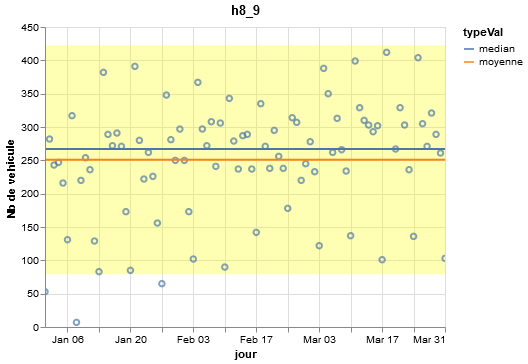

In [82]:
graphTrafHoraire(df_horaire,statsHoraires(df_horaire,'h8_9'),'h8_9')

In [81]:
alt.VConcatChart(vconcat=[alt.HConcatChart(hconcat=([graphTrafHoraire(df_horaire,statsHoraires(df_horaire,attributHeure),attributHeure) 
                           for attributHeure in [f'h{i+j}_{i+j+1}' for i in range(4)]])) for j in range(0,21,4)])

> ## **Visu de la répartition horaires des données en MJA et MJO**

In [6]:
with ct.ConnexionBdd('gti_otv_pg11') as c:
    rqt="select * from comptage.na_2010_2019_horaire where id_comptag IN (SELECT id_comptag FROM comptage.na_2010_2019_p WHERE gestionnai='DIRA' and id_comptag is not null)"
    df=pd.read_sql(rqt,c.sqlAlchemyConn)

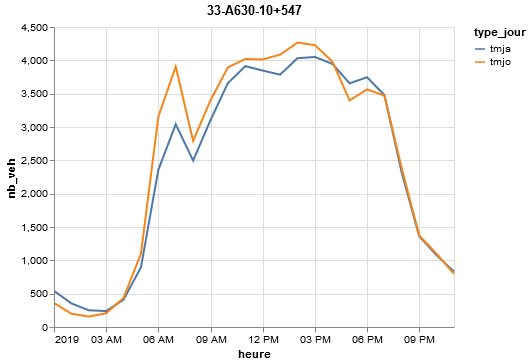

In [7]:
dh.GraphJourneeType(df,'33-A630-10+547')

# **Exemple de Graph sur une df horaire de la DIRCO**
> pour comparer 2 sens de circu

In [10]:
fichierMja=r'Q:\DAIT\TI\DREAL33\2020\OTV\Doc_travail\Donnees_source\DIRCO\TMJA DIRCO-NA 2019_unfused.csv'
fichierMjM=r'Q:\DAIT\TI\DREAL33\2020\OTV\Doc_travail\Donnees_source\DIRCO\TMJM DIRCO-NA 2019.ods'
dossierHoraire=r'Q:\DAIT\TI\DREAL33\2020\OTV\Doc_travail\Donnees_source\DIRCO\données dirco'
dirco=it.Comptage_Dirco(fichierMja,fichierMjM,dossierHoraire,'2019')

dfFichierTmja=dirco.miseEnFormeFichierTmjaPourHoraire()
dfSc=dirco.miseEnFormeHoraire(dirco.tousFichierHoraires(dfFichierTmja))
dfScParSens,dicoCptok,dicoCptAssym=dirco.horaireParSens(dfSc)

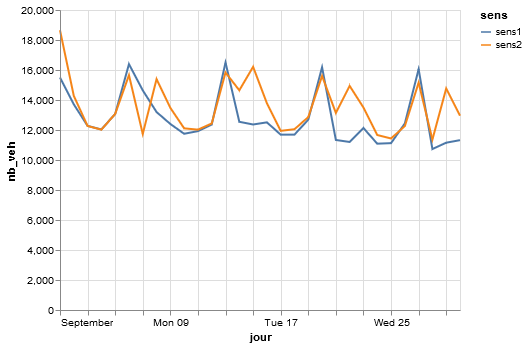

In [11]:
dh.graph2SensParJour(dicoCptok['19-A20-229+500'])

# **Exemple de Graph d'évolution a partir des donnees de l'affaire sncf-reseau**
> cf Q:\DAIT\TI\RFF-Sncf_reseau\2020 por plus de details

In [12]:
rqt="""WITH 
jointure AS (
SELECT s.*, t.id_comptag
 FROM sncf_pn_a_completer s LEFT JOIN lineaire.traf2019_bdt33_ed19_l t ON (s.id_otv_proche=t.id_ign)),
id_comptag_sncf_reseau as(
SELECT id_pt_otv2019 id_comptag
 FROM jointure
 WHERE id_pt_otv2019  IS NOT null
UNION 
SELECT id_comptag
 FROM jointure
 WHERE id_comptag IS NOT NULL),
otv_ligne AS (
SELECT id_comptag,unnest(array[2019, 2018, 2017,2016,2015,2014,2013,2012,2011,2010]) AS annee,
       unnest(array[tmja_2019, tmja_2018, tmja_2017,tmja_2016,tmja_2015, tmja_2014,tmja_2013,tmja_2012,tmja_2011,tmja_2010]) AS tmja,
       unnest(array[pc_pl_2019, pc_pl_2018, pc_pl_2017,pc_pl_2016,pc_pl_2015, pc_pl_2014,pc_pl_2013,pc_pl_2012,pc_pl_2011,pc_pl_2010]) AS pc_pl
 FROM comptage.na_2010_2019_p
 WHERE id_comptag IN (SELECT id_comptag FROM id_comptag_sncf_reseau )),
trafic_non_null AS (
 SELECT * 
  FROM otv_ligne
  WHERE tmja IS NOT NULL
  ORDER BY id_comptag, annee DESC), 
val_tmja AS (
 SELECT id_comptag,
    tmja,
    lead(tmja) OVER w AS tmja_prec,
    first_value(tmja) OVER w AS tmja_recent,
    last_value(tmja) OVER w AS tmja_ancien,
    annee,
    max(annee) OVER (PARTITION BY id_comptag) - min(annee) OVER (PARTITION BY id_comptag) AS nb_annees_tot,
    annee - lead(annee) OVER w::integer AS nb_annees_prec
   FROM trafic_non_null
  WINDOW w AS (PARTITION BY id_comptag ORDER BY annee DESC ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
  ORDER BY id_comptag, annee DESC, tmja DESC), 
evolutions AS (
 SELECT id_comptag,
    tmja,
    tmja_prec,
    tmja_recent,
    tmja_ancien,
    annee,
    nb_annees_tot,
    nb_annees_prec,
        CASE
            WHEN nb_annees_prec > 0 THEN comptage.evol_annuelle_traf(tmja, tmja_prec, nb_annees_prec)
            ELSE NULL::numeric
        END AS evol_anuelle,
        CASE
            WHEN nb_annees_tot > 0 THEN comptage.evol_annuelle_traf(tmja_recent, tmja_ancien, nb_annees_tot)
            ELSE NULL::numeric
        END AS evol_annuelle_globale,
        CASE
            WHEN tmja_prec > 0 THEN round((tmja::numeric / tmja_prec::numeric - 1::numeric) * 100::numeric, 2)
            ELSE NULL::numeric
        END AS evol_absolu_recente
   FROM val_tmja
  ORDER BY id_comptag, annee DESC
)
SELECT * FROM evolutions"""

In [13]:
with ct.ConnexionBdd('local_otv_gti') as c : 
    df=pd.read_sql(rqt,c.sqlAlchemyConn)

In [16]:
test=df.loc[df['id_comptag']=='33-D1010-20+300']

In [17]:
test

,id_comptag,tmja,tmja_prec,tmja_recent,tmja_ancien,annee,nb_annees_tot,nb_annees_prec,evol_anuelle,evol_annuelle_globale,evol_absolu_recente
0,33-D1010-20+300,3826,3890.0,3826,4899,2017,5,1.0,-1.65,-4.82,-1.65
1,33-D1010-20+300,3890,4760.0,3826,4899,2016,5,1.0,-18.28,-4.82,-18.28
2,33-D1010-20+300,4760,4790.0,3826,4899,2015,5,1.0,-0.63,-4.82,-0.63
3,33-D1010-20+300,4790,4899.0,3826,4899,2014,5,2.0,-1.12,-4.82,-2.22
4,33-D1010-20+300,4899,NaN,3826,4899,2012,5,NaN,NaN,-4.82,NaN


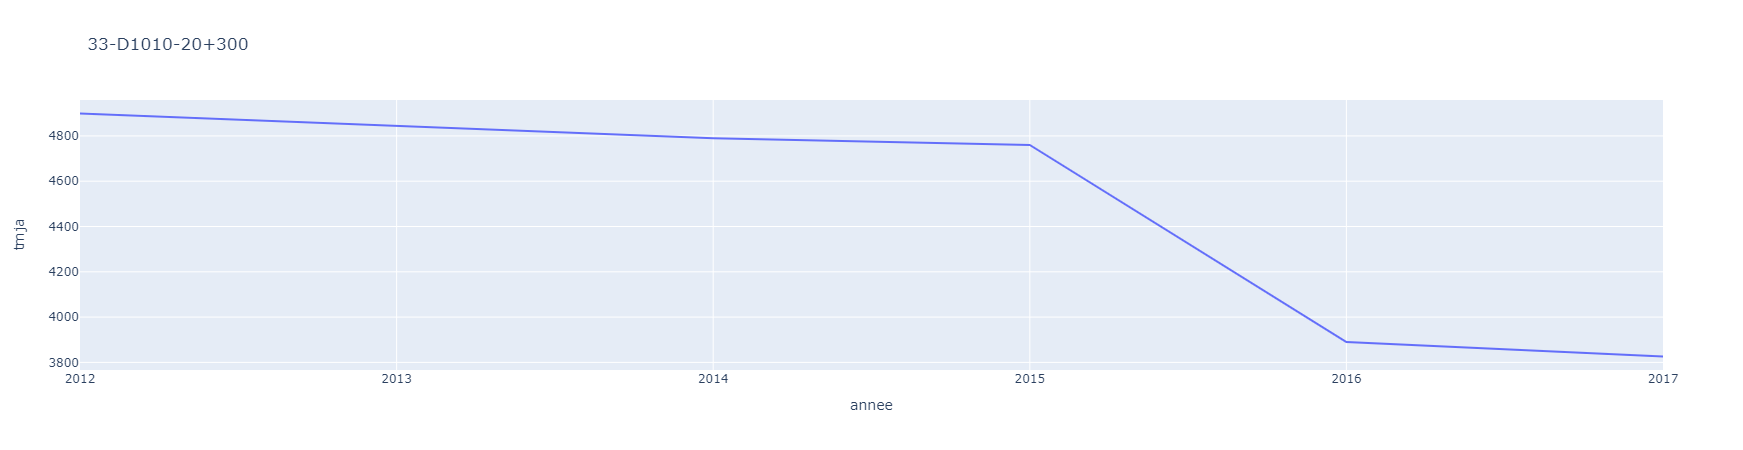

In [19]:
px.line(test, x='annee',y='tmja', title=test.id_comptag.unique()[0])

In [29]:
px.scatter(test.fillna(0), x='annee',y='evol_anuelle', title=f'point de mesures {test.id_comptag.unique()[0]} : evolution annuelle')

(Scatter({
     'hovertemplate': 'annee=%{x}<br>evol_anuelle=%{y}<extra></extra>',
     'legendgroup': '',
     'marker': {'color': '#636efa', 'symbol': 'circle'},
     'mode': 'markers',
     'name': '',
     'orientation': 'v',
     'showlegend': False,
     'x': array([2017, 2016, 2015, 2014, 2012], dtype=int64),
     'xaxis': 'x',
     'y': array([ -1.65, -18.28,  -0.63,  -1.12,   0.  ]),
     'yaxis': 'y'
 }),)

In [125]:
listIdComptag=df.id_comptag.unique()
nbPoints=len(listIdComptag)
titres=[e for a in [(f'{c} : trafics', f'{c} : evolutions annuelles,  moyenne = {df.loc[df.id_comptag==c].evol_annuelle_globale.unique()[0]}') for c in listIdComptag] for e in a]
fig = make_subplots(rows=nbPoints, cols=2, subplot_titles=titres,
                    horizontal_spacing=0.04,vertical_spacing=0.006)

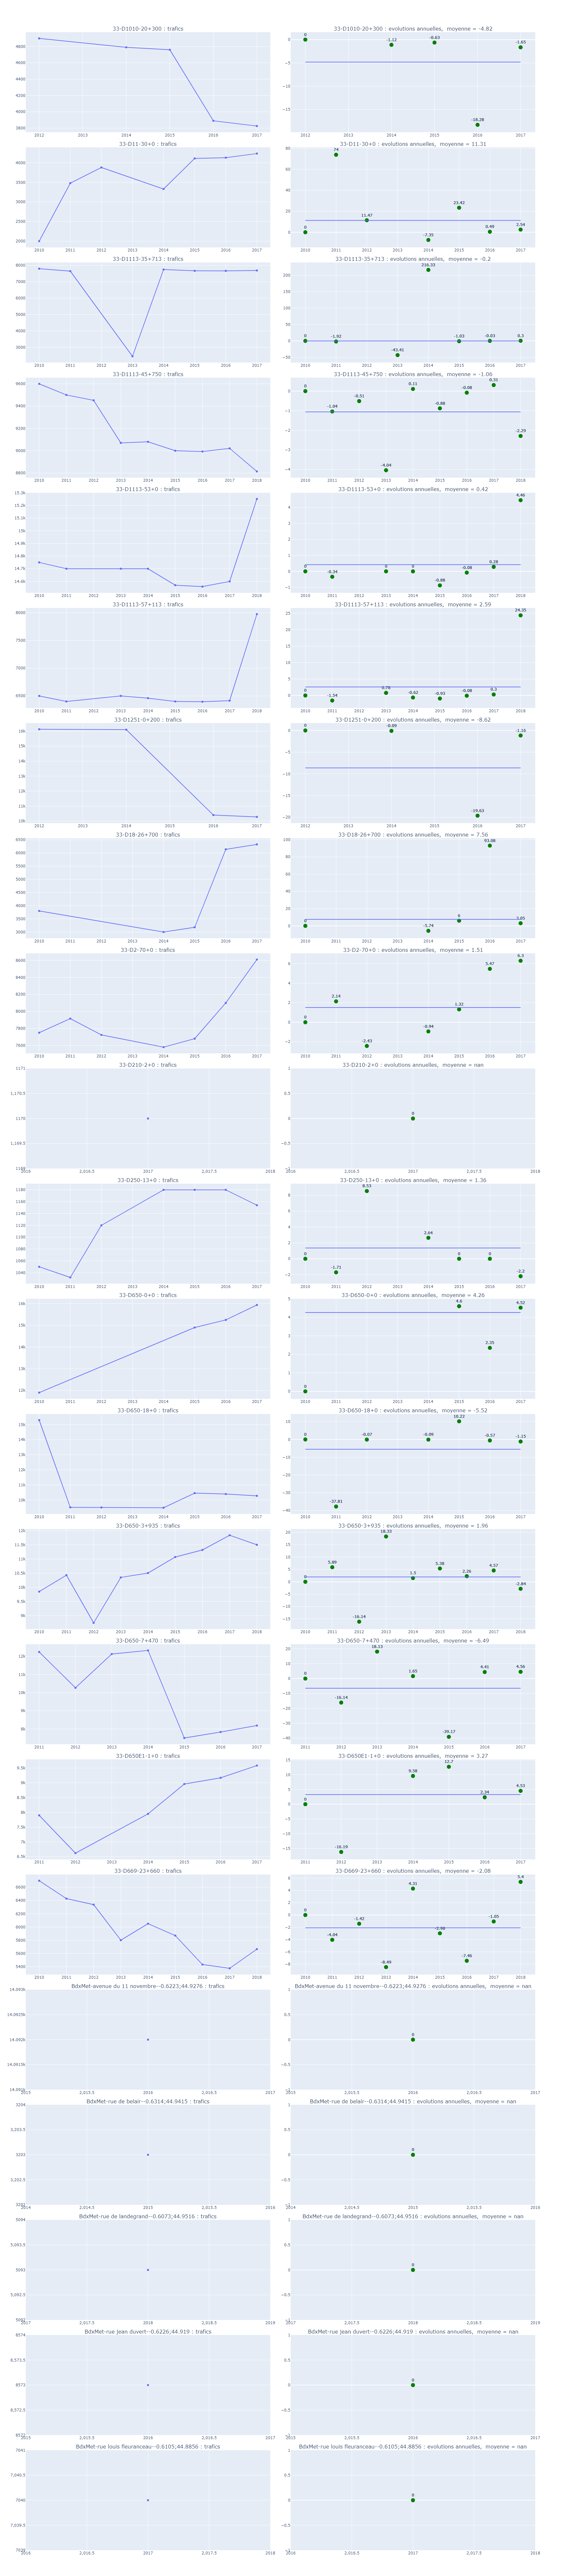

In [128]:
for i,c in enumerate(listIdComptag) : 
    dfIdUnique=df.loc[df['id_comptag']==c]
    fig.add_trace(px.scatter(dfIdUnique, x='annee',y='tmja')['data'][0], row=i+1,col=1)
    fig.add_trace(px.scatter(dfIdUnique.fillna(0), x='annee',y='evol_anuelle', text='evol_anuelle')['data'][0], row=i+1,col=2)
    fig.data[-1].update(marker=dict(size=12, color='green'),textposition='top center')
    fig.add_trace(px.line(dfIdUnique, x='annee',y='evol_annuelle_globale')['data'][0], row=i+1,col=2)
    #fig.data[-1].update(textposition='top center')
fig.update_layout(height=8000, width=1500)

In [86]:
nbPoints

22

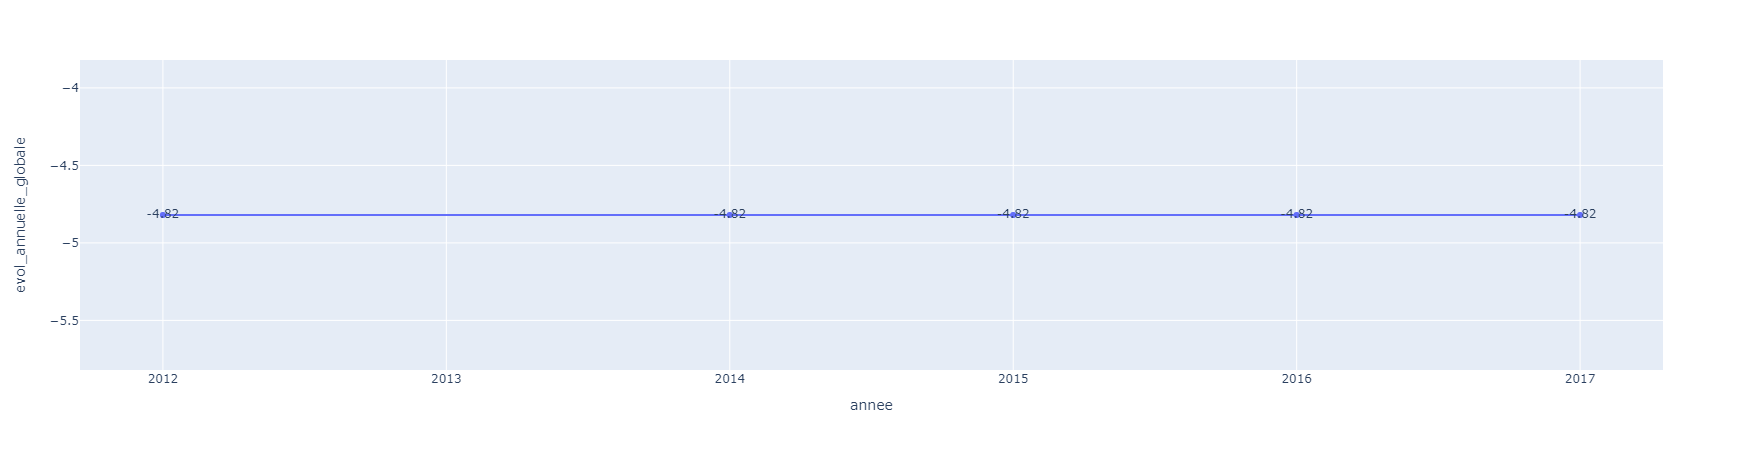

In [55]:
px.line(test, x='annee',y='evol_annuelle_globale', text='')